In [2]:
import warnings
warnings.filterwarnings('ignore',category=FutureWarning)
warnings.filterwarnings('ignore',category=DeprecationWarning)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate, KFold, RepeatedKFold, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.linear_model import LinearRegression
import time
import cudf
from cuml.ensemble import RandomForestRegressor as cuRF
import math
from tqdm import tqdm
import xgboost as xgb

#### Output file

In [3]:
sourceFile = open("gpu_logs/shared_all_records.txt", 'w')

### Load the data

In [4]:
df = pd.read_csv("data/shared_all_records.csv")
df.reset_index(drop=True, inplace=True)
df = df.iloc[:, [0, 2, 1]]
df['Time'] =  pd.to_datetime(df['Time'])
df

,Time,Location,Energy
0,2020-10-06 00:15:00,PT41CV,0.076
1,2020-10-06 00:30:00,PT41CV,0.072
2,2020-10-06 00:45:00,PT41CV,0.072
3,2020-10-06 01:00:00,PT41CV,0.068
4,2020-10-06 01:15:00,PT41CV,0.032
...,...,...,...
1041355,2023-02-19 23:00:00,PT87ZW,NaN
1041356,2023-02-19 23:15:00,PT87ZW,NaN
1041357,2023-02-19 23:30:00,PT87ZW,NaN
1041358,2023-02-19 23:45:00,PT87ZW,NaN


In [5]:
## Number of houses
df.Location.nunique()

12

In [6]:
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)
df

,Time,Location,Energy
0,2020-10-06 00:15:00,PT41CV,0.076
1,2020-10-06 00:30:00,PT41CV,0.072
2,2020-10-06 00:45:00,PT41CV,0.072
3,2020-10-06 01:00:00,PT41CV,0.068
4,2020-10-06 01:15:00,PT41CV,0.032
...,...,...,...
576694,2022-11-25 00:00:00,PT87ZW,0.764
576695,2022-11-25 00:15:00,PT87ZW,0.660
576696,2022-11-25 00:30:00,PT87ZW,0.692
576697,2022-11-25 00:45:00,PT87ZW,0.660


In [7]:
## Number of records per house
df.Location.value_counts()

PT17RW    81584
PT41CV    75448
PT87ZW    74876
PT43QL    69208
PT87RW    53263
PT48JB    39545
PT44AL    39260
PT15VP    37916
PT69QG    37052
PT51SH    35036
PT42JN    29955
PT07ZR     3556
Name: Location, dtype: int64

In [8]:
#df.to_csv("../datasets/shared_complete.csv", index=False)

### Auxiliary functions

In [9]:
def plot_results(preds: np.array, actuals: np.array, title: str):
    
    plt.scatter(actuals, preds, c='b', label='predicted')
    plt.xlabel('actual')
    plt.ylabel('predicted')
    plt.title(title)
    plt.xlim(0, plt.xlim()[1])
    plt.ylim(0, plt.ylim()[1])
    _ = plt.plot([0, 100], [0, 100], '--r', label='y=x')
    plt.legend()
    plt.show()

def truncate_metric(metric):
    m = math.trunc(10000 * metric) / 10000
    return m 
    
def performance_metrics(preds: np.array, actuals: np.array, filename):

    # calculate performance metrics
    
    mse = truncate_metric(mean_squared_error(actuals, preds))
    wape = truncate_metric(np.sum(np.abs(preds - actuals)) / np.sum(np.abs(actuals))) * 100
    r2 = truncate_metric(r2_score(actuals, preds))
    
    # print performance metrics
    print('MSE: %.4f' % mse, file=filename)
    print('WAPE: %.2f' % wape, file=filename)
    print('R2: %.4f' % r2, file=filename)
    return mse, wape, r2

#@jit(target_backend='cuda')
def build_model(estimator, X_train: np.array, y_train: np.array, X_test: np.array):
    
    model = estimator
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    
    return model, preds

def validate(estimator, X_train, y_train):
    scores = cross_validate(estimator, X_train, y_train, scoring=['r2', 'neg_mean_squared_error'])
    return scores

In [10]:
def total_averaged_metrics(metrics_list, filename):
    
    print("Total Averaged MSE: {}".format(np.round(sum(i for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged WAPE: {}".format(np.round(sum(j for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)
    print("Total Averaged R2: {}".format(np.round(sum(k for i, j, k in metrics_list)/len(metrics_list),3)), file=filename)

def past_timesteps(df, number_of_timesteps):
    for i in tqdm(range(1, (number_of_timesteps + 1))):
        df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
    df.dropna(inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

# def last_energy_points_full(df, number_timesteps, num_samples_per_house):
#     X = pd.DataFrame()
#     other_feats = df.iloc[:,:2]
#     for i in range(1, (number_timesteps + 1) ):
#         X[f'Energy_{i*15}'] = df['Energy'].shift(i)
#     y = df.copy().iloc[:,2]
#     y.iloc[:number_timesteps] = np.nan
#     ## Remove samples in between each house
#     for h in range(1, number_of_houses):
#         for i in range(0, number_timesteps):
#             X.iloc[(num_samples_per_house+i)*h] = np.nan
#             y.iloc[(num_samples_per_house+i)*h] = np.nan
#     X = pd.concat([other_feats, X], axis=1)
#     X.dropna(inplace=True)
#     X.reset_index(drop=True, inplace=True)
#     y.dropna(inplace=True)
#     y.reset_index(drop=True, inplace=True)
#     y.columns = ["Energy"]
#     dataframe = pd.concat([X,y.rename('Energy')], axis=1)
#     assert number_of_houses == (df.shape[0] - dataframe.shape[0]) / number_timesteps, "Something went wrong with preprocessing"
#     return dataframe
    

In [11]:
def normalize_training(X_train):
    scaler = MinMaxScaler(feature_range=(0,1))
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    return X_train, scaler

### Cross Validate

In [ ]:
#scores = validate(model, X_train, y_train)
#cv_mse = np.round(scores['test_neg_mean_squared_error'].mean() * (-1),4)
#cv_r2 = np.round(scores['test_r2'].mean(),5)
#print("CV MSE: {} ".format(cv_mse))
#print("CV R2: {} ".format(cv_r2))
#metrics_list.append((cv_mse,cv_rmse,cv_mae,mape,cv_r2))

## Leave 10 houses for test (demonstration)

In [12]:
number_of_timesteps = 672

In [13]:
locations = np.random.choice(df['Location'].unique(), size=3, replace=False)
locations

array(['PT44AL', 'PT48JB', 'PT69QG'], dtype=object)

In [14]:
df_new = past_timesteps(df, number_of_timesteps)
df_new

 12%|█▎        | 84/672 [00:00<00:04, 133.84it/s]/tmp/ipykernel_4022204/223892406.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
 15%|█▍        | 98/672 [00:00<00:04, 134.37it/s]/tmp/ipykernel_4022204/223892406.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.loc[df['Time'].shift(i) == df['Time'] - pd.Timedelta(i * 15, 'm'), f"energy_lag_{i}"] = df['Energy'].shift(i)
/tmp/ipykernel_4022204/223892406.py:9: P

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_663,energy_lag_664,energy_lag_665,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672
0,2020-10-13 00:15:00,PT41CV,0.036,0.080,0.084,0.088,0.096,0.100,0.104,0.108,...,0.120,0.040,0.048,0.120,0.040,0.032,0.068,0.072,0.072,0.076
1,2020-10-13 00:30:00,PT41CV,0.084,0.036,0.080,0.084,0.088,0.096,0.100,0.104,...,0.064,0.120,0.040,0.048,0.120,0.040,0.032,0.068,0.072,0.072
2,2020-10-13 00:45:00,PT41CV,0.104,0.084,0.036,0.080,0.084,0.088,0.096,0.100,...,0.028,0.064,0.120,0.040,0.048,0.120,0.040,0.032,0.068,0.072
3,2020-10-13 01:00:00,PT41CV,0.036,0.104,0.084,0.036,0.080,0.084,0.088,0.096,...,0.092,0.028,0.064,0.120,0.040,0.048,0.120,0.040,0.032,0.068
4,2020-10-13 01:15:00,PT41CV,0.060,0.036,0.104,0.084,0.036,0.080,0.084,0.088,...,0.080,0.092,0.028,0.064,0.120,0.040,0.048,0.120,0.040,0.032
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554229,2022-11-25 00:00:00,PT87ZW,0.764,0.812,0.756,0.784,0.928,0.960,0.868,1.016,...,0.432,0.552,0.504,0.436,0.428,0.440,0.520,0.532,0.472,0.544
554230,2022-11-25 00:15:00,PT87ZW,0.660,0.764,0.812,0.756,0.784,0.928,0.960,0.868,...,0.424,0.432,0.552,0.504,0.436,0.428,0.440,0.520,0.532,0.472
554231,2022-11-25 00:30:00,PT87ZW,0.692,0.660,0.764,0.812,0.756,0.784,0.928,0.960,...,0.452,0.424,0.432,0.552,0.504,0.436,0.428,0.440,0.520,0.532
554232,2022-11-25 00:45:00,PT87ZW,0.660,0.692,0.660,0.764,0.812,0.756,0.784,0.928,...,0.448,0.452,0.424,0.432,0.552,0.504,0.436,0.428,0.440,0.520


In [16]:
df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
df_new['Hour'] = df_new['Time'].dt.hour
df_new

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2020-10-13 00:15:00,PT41CV,0.036,0.080,0.084,0.088,0.096,0.100,0.104,0.108,...,0.120,0.040,0.032,0.068,0.072,0.072,0.076,1,0,0
1,2020-10-13 00:30:00,PT41CV,0.084,0.036,0.080,0.084,0.088,0.096,0.100,0.104,...,0.048,0.120,0.040,0.032,0.068,0.072,0.072,1,0,0
2,2020-10-13 00:45:00,PT41CV,0.104,0.084,0.036,0.080,0.084,0.088,0.096,0.100,...,0.040,0.048,0.120,0.040,0.032,0.068,0.072,1,0,0
3,2020-10-13 01:00:00,PT41CV,0.036,0.104,0.084,0.036,0.080,0.084,0.088,0.096,...,0.120,0.040,0.048,0.120,0.040,0.032,0.068,1,0,1
4,2020-10-13 01:15:00,PT41CV,0.060,0.036,0.104,0.084,0.036,0.080,0.084,0.088,...,0.064,0.120,0.040,0.048,0.120,0.040,0.032,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554229,2022-11-25 00:00:00,PT87ZW,0.764,0.812,0.756,0.784,0.928,0.960,0.868,1.016,...,0.436,0.428,0.440,0.520,0.532,0.472,0.544,4,0,0
554230,2022-11-25 00:15:00,PT87ZW,0.660,0.764,0.812,0.756,0.784,0.928,0.960,0.868,...,0.504,0.436,0.428,0.440,0.520,0.532,0.472,4,0,0
554231,2022-11-25 00:30:00,PT87ZW,0.692,0.660,0.764,0.812,0.756,0.784,0.928,0.960,...,0.552,0.504,0.436,0.428,0.440,0.520,0.532,4,0,0
554232,2022-11-25 00:45:00,PT87ZW,0.660,0.692,0.660,0.764,0.812,0.756,0.784,0.928,...,0.432,0.552,0.504,0.436,0.428,0.440,0.520,4,0,0


In [17]:
df_new.to_csv("data/shared_oneweek.csv", index=False)

In [25]:
def test_leave_house_out(df, estimator, locations, filename):
    # df_new = past_timesteps(df, number_timesteps)
    # df_new['DayOfWeek'] = df_new['Time'].dt.dayofweek
    # df_new['Weekend'] = df_new['Time'].dt.dayofweek.isin([5,6]).astype(int)
    # df_new['Hour'] = df_new['Time'].dt.hour
    test = df_new[df_new['Location'].isin(locations)]
    train = df_new[~df_new['Location'].isin(locations)]
    print("Train set: ", train.shape)
    print("Test set: ", test.shape)
    X_train = train.drop(['Time', 'Energy', 'Location'], axis=1)
    X_test = test.drop(['Time', 'Energy', 'Location'], axis=1)
    y_train = train['Energy']
    y_test = test['Energy']
    X_train_norm, scaler = normalize_training(X_train)
    X_test_norm = scaler.transform(X_test)

    model = estimator
    init = time.time()
    model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    end = time.time()
    print('Elapsed time: {:.4f} s'.format(end - init), file=filename)
    mse, wape, r2 = performance_metrics(y_pred, y_test.values.reshape(-1), filename)
    return mse, wape, r2, model

## Predict  10 folds with 10 random houses for test

In [19]:
df = pd.read_csv("data/shared_oneweek.csv")
df

,Time,Location,Energy,energy_lag_1,energy_lag_2,energy_lag_3,energy_lag_4,energy_lag_5,energy_lag_6,energy_lag_7,...,energy_lag_666,energy_lag_667,energy_lag_668,energy_lag_669,energy_lag_670,energy_lag_671,energy_lag_672,DayOfWeek,Weekend,Hour
0,2020-10-13 00:15:00,PT41CV,0.036,0.080,0.084,0.088,0.096,0.100,0.104,0.108,...,0.120,0.040,0.032,0.068,0.072,0.072,0.076,1,0,0
1,2020-10-13 00:30:00,PT41CV,0.084,0.036,0.080,0.084,0.088,0.096,0.100,0.104,...,0.048,0.120,0.040,0.032,0.068,0.072,0.072,1,0,0
2,2020-10-13 00:45:00,PT41CV,0.104,0.084,0.036,0.080,0.084,0.088,0.096,0.100,...,0.040,0.048,0.120,0.040,0.032,0.068,0.072,1,0,0
3,2020-10-13 01:00:00,PT41CV,0.036,0.104,0.084,0.036,0.080,0.084,0.088,0.096,...,0.120,0.040,0.048,0.120,0.040,0.032,0.068,1,0,1
4,2020-10-13 01:15:00,PT41CV,0.060,0.036,0.104,0.084,0.036,0.080,0.084,0.088,...,0.064,0.120,0.040,0.048,0.120,0.040,0.032,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
554229,2022-11-25 00:00:00,PT87ZW,0.764,0.812,0.756,0.784,0.928,0.960,0.868,1.016,...,0.436,0.428,0.440,0.520,0.532,0.472,0.544,4,0,0
554230,2022-11-25 00:15:00,PT87ZW,0.660,0.764,0.812,0.756,0.784,0.928,0.960,0.868,...,0.504,0.436,0.428,0.440,0.520,0.532,0.472,4,0,0
554231,2022-11-25 00:30:00,PT87ZW,0.692,0.660,0.764,0.812,0.756,0.784,0.928,0.960,...,0.552,0.504,0.436,0.428,0.440,0.520,0.532,4,0,0
554232,2022-11-25 00:45:00,PT87ZW,0.660,0.692,0.660,0.764,0.812,0.756,0.784,0.928,...,0.432,0.552,0.504,0.436,0.428,0.440,0.520,4,0,0


In [21]:
df.isna().sum().sum()

0

In [22]:
num_houses_test = 3

In [23]:
locations = []
for i in range(10):
    np.random.seed(i*4)
    l = np.random.choice(df['Location'].unique(), size=num_houses_test, replace=False)
    locations.append(l)
locations

[array(['PT48JB', 'PT87ZW', 'PT69QG'], dtype=object),
 array(['PT15VP', 'PT69QG', 'PT48JB'], dtype=object),
 array(['PT87RW', 'PT17RW', 'PT51SH'], dtype=object),
 array(['PT51SH', 'PT07ZR', 'PT17RW'], dtype=object),
 array(['PT87RW', 'PT42JN', 'PT41CV'], dtype=object),
 array(['PT87RW', 'PT44AL', 'PT43QL'], dtype=object),
 array(['PT87ZW', 'PT07ZR', 'PT17RW'], dtype=object),
 array(['PT87ZW', 'PT42JN', 'PT51SH'], dtype=object),
 array(['PT41CV', 'PT17RW', 'PT42JN'], dtype=object),
 array(['PT15VP', 'PT41CV', 'PT48JB'], dtype=object)]

### Linear Regression

In [26]:
metrics_list_lr = []
print("\n----------------------------", file=sourceFile)
print("\nLinear Regression\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_lr = test_leave_house_out(df, LinearRegression(), locations[i], sourceFile)
    metrics_list_lr.append((mse, wape, r2))

Train set:  (407465, 678)
Test set:  (146769, 678)
Train set:  (443753, 678)
Test set:  (110481, 678)
Train set:  (393087, 678)
Test set:  (161147, 678)
Train set:  (439723, 678)
Test set:  (114511, 678)
Train set:  (402960, 678)
Test set:  (151274, 678)
Train set:  (399895, 678)
Test set:  (154339, 678)
Train set:  (400555, 678)
Test set:  (153679, 678)
Train set:  (419071, 678)
Test set:  (135163, 678)
Train set:  (373967, 678)
Test set:  (180267, 678)
Train set:  (406029, 678)
Test set:  (148205, 678)


### XGBoost

In [27]:
metrics_list_xgb = []
print("\n----------------------------", file=sourceFile)
print("\nXGBoost\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_xgb = test_leave_house_out(df, xgb.XGBRegressor(tree_method='gpu_hist', seed=0), locations[i], sourceFile)
    metrics_list_xgb.append((mse, wape, r2))

Train set:  (407465, 678)
Test set:  (146769, 678)
Train set:  (443753, 678)
Test set:  (110481, 678)
Train set:  (393087, 678)
Test set:  (161147, 678)
Train set:  (439723, 678)
Test set:  (114511, 678)
Train set:  (402960, 678)
Test set:  (151274, 678)
Train set:  (399895, 678)
Test set:  (154339, 678)
Train set:  (400555, 678)
Test set:  (153679, 678)
Train set:  (419071, 678)
Test set:  (135163, 678)
Train set:  (373967, 678)
Test set:  (180267, 678)
Train set:  (406029, 678)
Test set:  (148205, 678)


### Random Forest

In [28]:
metrics_list_rf = []
print("\n----------------------------", file=sourceFile)
print("\nRandom Forest\n", file=sourceFile)
print("----------------------------\n", file=sourceFile)
for i in range(10):
    print("\nIteration", i, file=sourceFile)
    mse, wape, r2, model_rf = test_leave_house_out(df, cuRF(), locations[i], sourceFile)
    metrics_list_rf.append((mse, wape, r2))

Train set:  (407465, 678)
Test set:  (146769, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (443753, 678)
Test set:  (110481, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (393087, 678)
Test set:  (161147, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (439723, 678)
Test set:  (114511, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (402960, 678)
Test set:  (151274, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (399895, 678)
Test set:  (154339, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (400555, 678)
Test set:  (153679, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (419071, 678)
Test set:  (135163, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (373967, 678)
Test set:  (180267, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


Train set:  (406029, 678)
Test set:  (148205, 678)


/home/francisco.monteiro@av.it.pt/miniconda3/envs/rapids-23.02/lib/python3.8/site-packages/cuml/internals/api_decorators.py:190: UserWarning: To use pickling first train using float32 data to fit the estimator
  ret = func(*args, **kwargs)


## Averaged Metrics

In [29]:
print("\n\n\n", file=sourceFile)

In [30]:
print("\nLinear Regression", file=sourceFile)
total_averaged_metrics(metrics_list_lr, sourceFile)

In [31]:
print("\nXGBoost", file=sourceFile)
total_averaged_metrics(metrics_list_xgb, sourceFile)

In [32]:
print("\nRandom Forest", file=sourceFile)
total_averaged_metrics(metrics_list_rf, sourceFile)

### Feature Importance

In [33]:
print('Linear Regression\n')
for i,v in enumerate(model_lr.coef_):
    print('Feature: %0d, Score: %.5f' % (i,v))
print('XGBoost\n')
for i,v in enumerate(model_xgb.feature_importances_):
    print('Feature: %0d, Score: %.5f' % (i,v))

Linear Regression

Feature: 0, Score: 10.24276
Feature: 1, Score: -1.09480
Feature: 2, Score: 0.96050
Feature: 3, Score: 0.01154
Feature: 4, Score: 0.25485
Feature: 5, Score: 0.20321
Feature: 6, Score: 0.45786
Feature: 7, Score: -0.30674
Feature: 8, Score: 0.16806
Feature: 9, Score: -0.07546
Feature: 10, Score: 0.14608
Feature: 11, Score: 0.05312
Feature: 12, Score: 0.11346
Feature: 13, Score: -0.06105
Feature: 14, Score: 0.04556
Feature: 15, Score: 0.05512
Feature: 16, Score: -0.01129
Feature: 17, Score: 0.00621
Feature: 18, Score: 0.09675
Feature: 19, Score: 0.01116
Feature: 20, Score: 0.09445
Feature: 21, Score: -0.09255
Feature: 22, Score: 0.03274
Feature: 23, Score: 0.03985
Feature: 24, Score: 0.00789
Feature: 25, Score: -0.04847
Feature: 26, Score: 0.03878
Feature: 27, Score: -0.00303
Feature: 28, Score: 0.08671
Feature: 29, Score: -0.07293
Feature: 30, Score: 0.00998
Feature: 31, Score: -0.00517
Feature: 32, Score: 0.01414
Feature: 33, Score: 0.05264
Feature: 34, Score: -0.01841

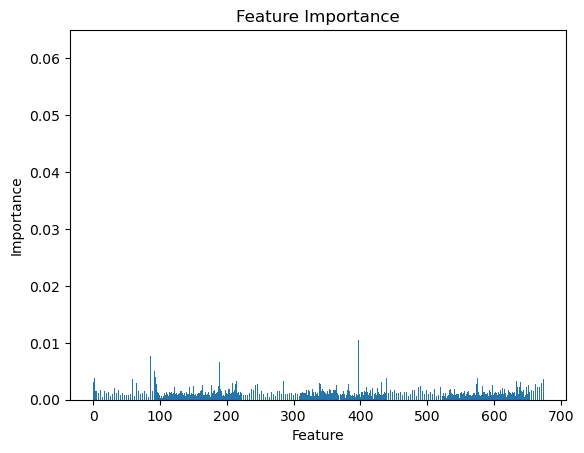

In [34]:
plt.bar(range(len(model_xgb.feature_importances_)),model_xgb.feature_importances_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

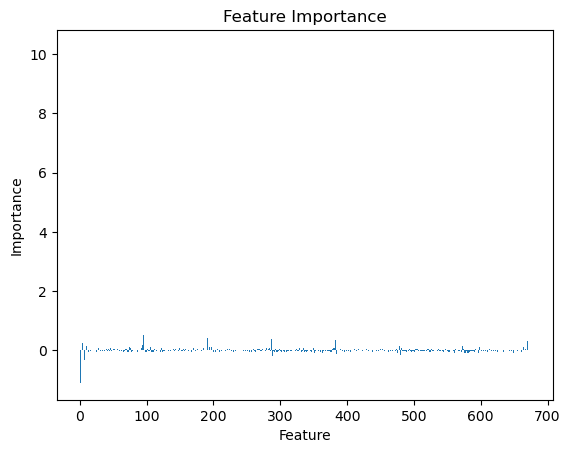

In [35]:
plt.bar(range(len(model_lr.coef_)),model_lr.coef_)
plt.title('Feature Importance')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

In [36]:
sourceFile.close()